<a href="https://colab.research.google.com/github/trilgar/MSM-2021/blob/main/Attention_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
%%capture
!pip install transformers
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt 

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        print("started creating dataframe")
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]
        self.labels = list(df['category'])
        print("creating completed")

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [21]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

                                                text  category
0  Unfortunately, the frustration of being Dr. Go...         0
1  Been going to Dr. Goldberg for over 10 years. ...         1
2  I don't know what Dr. Goldberg was like before...         0
3  I'm writing this review to give you a heads up...         0
4  All the food is great here. But the best thing...         1
                                                text  category
0  Contrary to other reviews, I have zero complai...         1
1  Last summer I had an appointment to get new ti...         0
2  Friendly staff, same starbucks fair you get an...         1
3  The food is good. Unfortunately the service is...         0
4  Even when we didn't have a car Filene's Baseme...         1
4480 1120
started creating dataframe
creating completed
started creating dataframe
creating completed


100%|██████████| 2240/2240 [17:02<00:00,  2.19it/s]


Epochs: 1 | Train Loss:  0.382 | Train Accuracy:  0.724 | Val Loss:  0.153 | Val Accuracy:  0.902


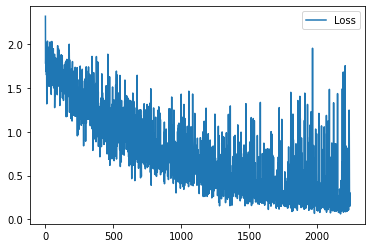

In [22]:
prefix = '/content/drive/MyDrive/msm4/'

train_df = pd.read_csv(prefix + 'train.csv', header=None)
train_df.head()

eval_df = pd.read_csv(prefix + 'test.csv', header=None)
eval_df.head()

train_df[0] = (train_df[0] == 2).astype(int)
eval_df[0] = (eval_df[0] == 2).astype(int)

train_df = pd.DataFrame({
    'text': train_df[1].replace(r'\n', ' ', regex=True),
    'category': train_df[0]
})

print(train_df.head())

eval_df = pd.DataFrame({
    'text': eval_df[1].replace(r'\n', ' ', regex=True),
    'category': eval_df[0]
})

print(eval_df.head())


def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()
    loss = []
    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device, dtype = torch.long)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label)
            loss.append(batch_loss)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        total_loss_val = 0
        total_acc_val = 0
        with torch.no_grad():

            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
        torch.save(model.state_dict(), '/content/drive/MyDrive/msm4/model.cpkt')
        # plot and save loss
        plt.figure()
        plt.plot(loss, label='Loss')
        plt.legend()
        plt.savefig('/content/drive/MyDrive/msm4/loss.png')

def evaluate(model, test_data):
    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device, dtype=torch.long)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')


train_df = train_df.sample(frac=0.01)
eval_df = eval_df.sample(frac = 0.01)
df_train = train_df.sample(frac=0.8, random_state=42)
df_val = train_df.drop(df_train.index)
print(len(df_train), len(df_val))

EPOCHS = 1
model = BertClassifier()
LR = 1e-6

train(model, df_train, df_val, LR, EPOCHS)



In [24]:
evaluate(model, eval_df)

started creating dataframe
creating completed
Test Accuracy:  0.889
